In [25]:
from scipy import stats
from copy import deepcopy
import numpy as np
import pickle
import os

import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt

import sys
sys.path.append("/Users/will_milligan/PycharmProjects/MUTATOR_FINAL") # adds parent directory to path
import stationary_distribution_aug as sd
from mutator_classes import Parameters

sns.set_style('whitegrid')
mpl.rcParams['figure.dpi'] = 400
mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['legend.fontsize'] = 10

# whereever the individual ARG runs were stored
in_dir = '/Users/will_milligan/PycharmProjects/MUTATOR_FINAL/01122022_trees'

In [26]:
# load individual args and decide that we will only use 100 of them
files = os.listdir(in_dir)
num_trees = 100

In [27]:
# determine the maximum length out of all ARG summary
max_length = 0

# load summaries of all trees
for f_index,f in enumerate(files):
    if f_index >= num_trees: continue
    with open(os.path.join(in_dir,f),'rb') as fin:
        (eur,afr,anc) = pickle.load(fin)
    max_length = max(max_length,len(eur))

In [28]:
# create objects to store results
eur_traj,afr_traj,anc_traj = (np.empty([num_trees,max_length]),
                              np.empty([num_trees,max_length]),
                              np.empty([num_trees,max_length]))

# load summaries of all trees
for f_index,f in enumerate(files):
    if f_index >= num_trees: continue
    with open(os.path.join(in_dir,f),'rb') as fin:
        (eur,afr,anc) = pickle.load(fin)
        eur_traj[f_index,:len(eur)] = eur
        afr_traj[f_index,:len(afr)] = afr
        anc_traj[f_index,:len(anc)] = anc

In [39]:
# defines methods of how to bin and summarize tree summaries
def bin_trajectories(traj,bin_method = 'log',bins = 100,mode='mean',start = 1, end = 1e6):
    
    if bin_method == 'log':
        bin_windows = np.logspace(np.log10(start),np.log10(end),bins)
    elif bin_method == 'linear':
        bin_windows = np.linspace(start,end,bins)
    else:
        raise ValueError('Bin method not understood')
        
    if mode == 'mean_mean':
        binned_traj = np.zeros([num_trees,bins])
    else:
        binned_traj = np.zeros([1,bins])
        
    for index,(i,j) in enumerate(zip(bin_windows[:-1],bin_windows[1:])):
        if mode == 'mean':
            binned_traj[:,index] = np.mean(np.mean(traj[:,int((i-1)):int((j-1))]))
        elif mode == 'mean_mean':
            binned_traj[:,index] = np.mean(traj[:,int((i-1)):int((j-1))])
        elif mode == 'var':
            binned_traj[:,index] = np.mean(np.std(traj[:,int((i-1)):int((j-1))],axis = 0))
            
    return binned_traj,bin_windows

In [46]:
def all_trajectories_figure(ax):
    n_bins = 500
    bin_method = 'log'
    
    # get summaries of args
    eur_bt_mean,bins_eur = bin_trajectories(eur_traj,bins = n_bins,mode = 'mean_mean',start = 60, end = max_length,bin_method=bin_method)
    afr_bt_mean,bins_afr = bin_trajectories(afr_traj,bins = n_bins,mode = 'mean_mean',start = 60, end = max_length,bin_method=bin_method)
    anc_bt_mean,bins_anc = bin_trajectories(anc_traj,bins = n_bins,mode = 'mean_mean',start = 60, end = max_length,bin_method=bin_method)
    
    # concatentate across args
    total_bins_eur = deepcopy(eur_bt_mean[0,:])*0
    total_bins_afr = deepcopy(eur_bt_mean[0,:])*0
    total_bins_anc = deepcopy(eur_bt_mean[0,:])*0
    
    for i in range(num_trees):
        
        total_bins_eur += eur_bt_mean[i,:]
        total_bins_afr += afr_bt_mean[i,:]
        total_bins_anc += anc_bt_mean[i,:]
    
    # determine how many mutational oppurtnities occur in simulated time
    total_bins = total_bins_afr+total_bins_anc+total_bins_eur
    magic_bin = max(np.where(bins_eur<60000)[0])
    remaining = (sum(total_bins_afr[:magic_bin])+sum(total_bins_anc[:magic_bin])+sum(total_bins_eur[:magic_bin]))/sum(total_bins_afr+total_bins_anc+total_bins_eur)  
    print(f'{remaining} proportion of mutational oppurtunities occur in the most recent {bins_eur[magic_bin]} generations')
    
    # plot end of simulated time
    ax.vlines([60000],ymin = 0, ymax = 1e13,colors=[0.7,0.7,0.7],ls=':')
    ax.text(x = 33000,y = 250, s = 'End of simulated\ntrajectories',rotation = 90,color = [0.6,0.6,0.6])
    
    # plot summaries for each population
    ax.plot(bins_eur,total_bins_eur,color = 'b', ls = '-',label = 'YRI Y(t)')
    ax.plot(bins_afr,total_bins_afr,color = 'r',  ls = '-', label = 'CEU C(t)')
    ax.plot(bins_anc,total_bins_anc,color = 'gold', ls = '-', label = 'Shared A(t)')

    # plotting stuff
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid([0.9]*3)
    ax.spines['bottom'].set_color('k')
    ax.spines['top'].set_color('k')
    ax.spines['left'].set_color('k')
    ax.spines['right'].set_color('k')
    ax.set_xticks(np.logspace(1,6,6))
    plt.sca(ax)
    plt.legend(framealpha = 1, edgecolor = 'k',loc='lower left',handlelength=1.5)
    plt.tick_params(bottom = True, left = True, labelleft = True, labelbottom = True, which='both')
    plt.xlabel('Time (generations before present)')
    plt.ylabel('Mutational opportunities')
    plt.title(r'$\bf{A.}$ Summaries of simulated ARG',pad = 10)

In [47]:
def relative_variance_figure(ax):
    
    # calculate summaries of args
    n_bins = 500
    bin_method = 'log'
    eur_bt,bins_eur = bin_trajectories(eur_traj,bins = n_bins,mode = 'var',start = 60, end = max_length,bin_method=bin_method)
    afr_bt,bins_afr = bin_trajectories(afr_traj,bins = n_bins,mode = 'var',start = 60, end = max_length,bin_method=bin_method)
    anc_bt,bins_anc = bin_trajectories(anc_traj,bins = n_bins,mode = 'var',start = 60, end = max_length,bin_method=bin_method)
    
    eur_bt_mean,bins_eur = bin_trajectories(eur_traj,bins = n_bins,mode = 'mean',start = 60, end = max_length,bin_method=bin_method)
    afr_bt_mean,bins_afr = bin_trajectories(afr_traj,bins = n_bins,mode = 'mean',start = 60, end = max_length,bin_method=bin_method)
    anc_bt_mean,bins_anc = bin_trajectories(anc_traj,bins = n_bins,mode = 'mean',start = 60, end = max_length,bin_method=bin_method)

    variance_scalar = 0.1
    
    ax.plot(bins_eur,(eur_bt_mean[0]/eur_bt[0,:])**(-1)/variance_scalar,color='r',alpha=1,ls='-')
    ax.plot(bins_afr,(afr_bt_mean[0]/afr_bt[0,:])**(-1)/variance_scalar,color='b',alpha=1,ls='-')
    ax.plot(bins_anc,(anc_bt_mean[0]/anc_bt[0,:])**(-1)/variance_scalar,color='gold',alpha=1,ls='-')
    
    ax.vlines([60000],ymin = 0, ymax = 1e2,colors=[0.7,0.7,0.7],ls=':')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid([0.9]*3)
    ax.spines['bottom'].set_color('k')
    ax.spines['top'].set_color('k')
    ax.spines['left'].set_color('k')
    ax.spines['right'].set_color('k')
    ax.set_xticks(np.logspace(1,6,6))
    plt.sca(ax)
#     plt.legend(framealpha = 1, edgecolor = [0.9,0.9,0.9,1],loc='lower left')
    plt.tick_params(bottom = True, left = True, labelleft = True, labelbottom = True, which='both')
    plt.xlabel('Time (generations before present)')
    plt.ylabel('SD relative to mean')
    plt.title(r'$\bf{B.}$ Estimated variance of genome-wide ARG',pad = 10)
    
    

0.9996881619578132 proportion of mutational oppurtunities occur in the most recent 59967.46928385221 generations


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


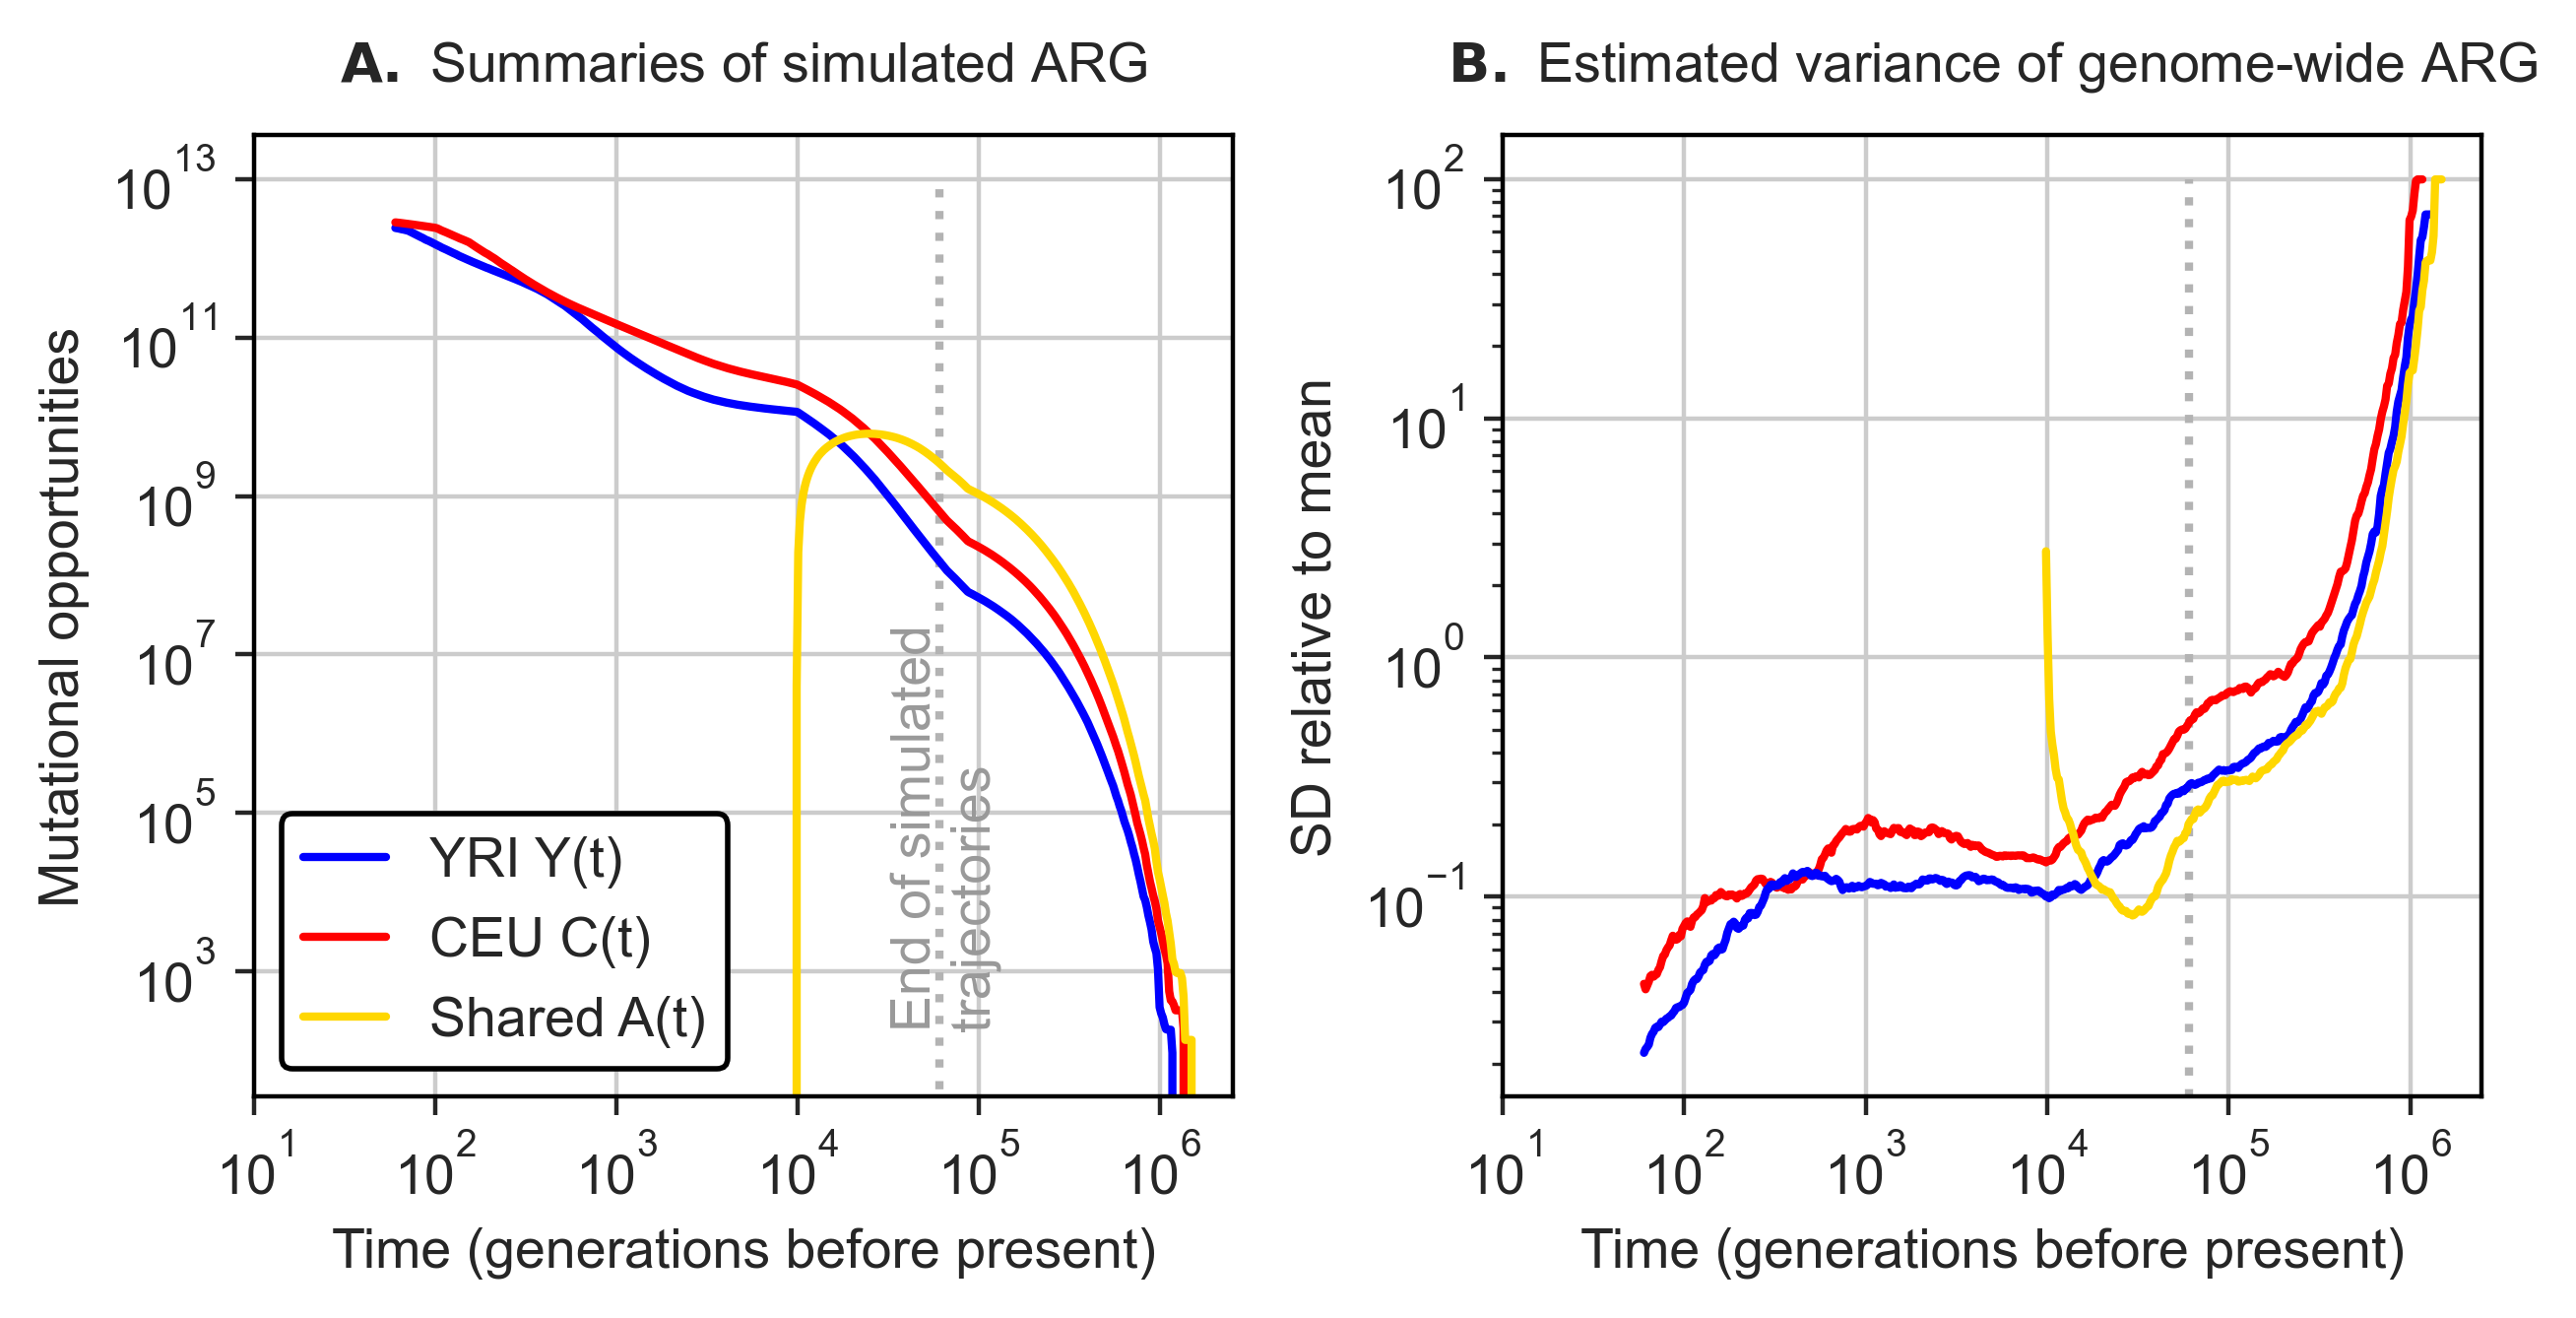

In [48]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(8*6.5/8,4.2425*6.5/8))
all_trajectories_figure(ax1)
relative_variance_figure(ax2)
plt.subplots_adjust(wspace = 0.3)

plt.tight_layout()